In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import functions
from sklearn.neighbors import NearestNeighbors
from scipy.stats import mode

In [2]:
from function_wrappers import *

In [3]:
functions.tnr(np.array([[9,11],[45,12]]))

0.45

In [4]:
gme = pd.read_csv('./gme.csv')
gme_r_v = pd.read_csv('./gme_weekly_return_volatility.csv')
gme_r_v = gme_r_v[[True if y in [2020,2021] else False for y in 
                   gme_r_v.Year.values]]

In [5]:
gme_wr_v = pd.read_csv('./gme_weekly_return_volatility.csv')
gme_wr_v = gme_wr_v[np.isin(gme_wr_v.Year.values,[2020,2021])]
gme_wr_v['Labels'] = pd.read_csv('./gme_labels.csv', header=None)[0].values

##### Q1 

In [6]:
# staggered dictionary
this_wk_last_wk = dict(zip(gme.Year_Week.unique()[1:], 
                           gme.Year_Week.unique()[:-1]))

In [7]:
scaler = StandardScaler()
le = LabelEncoder()

In [8]:
X = gme_wr_v[['mean_return','volatility']].values
y = gme_wr_v[['Labels']].values

y = 1 - le.fit_transform(np.ravel(y))
X_tr = X[gme_wr_v.Year == 2020]
y_tr = y[gme_wr_v.Year == 2020]
X_te = X[gme_wr_v.Year == 2021]
y_te = y[gme_wr_v.Year == 2021]
scaler.fit(X_tr)
X_tr = scaler.transform(X_tr)
X_te = scaler.transform(X_te)

###### l2 distance

For comparison with L1 / Manhattan

In [9]:
X = gme_wr_v
X_train = scaler.transform(X_tr)
accuracies={}
for k in range(3,12,2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_tr,y_tr)
    predictions = knn.predict(X_tr)
    accuracies[k] = np.round(knn.score(X_tr,y_tr),3)

In [10]:
accuracies

{3: 0.925, 5: 0.925, 7: 0.906, 9: 0.868, 11: 0.83}

[Text(0.5, 1.0, 'Accuracies by K Hyper-Parameter}'),
 Text(0.5, 0, 'K Value'),
 Text(0, 0.5, 'Accuracy')]

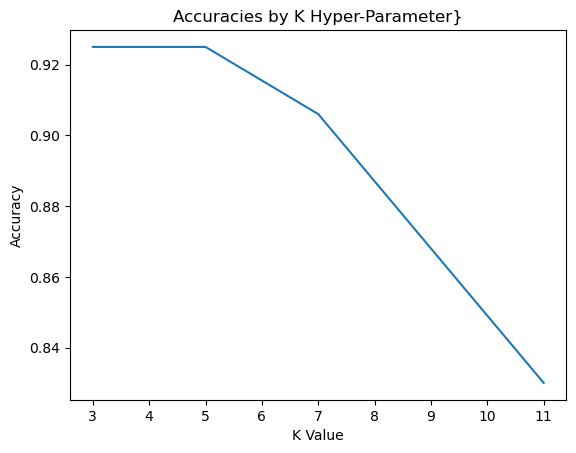

In [11]:
p = sns.lineplot(x = range(3,12,2), y = [accuracies[k] for k in range(3,12,2)])
p.set(title='Accuracies by K Hyper-Parameter}',xlabel='K Value', ylabel='Accuracy')

K values of 3 and 5 give the same accuracy of .925

In [12]:
knn = KNeighborsClassifier(n_neighbors=3,p=2)
knn.fit(X_tr,y_tr)
predictions = knn.predict(X_te)
np.round(knn.score(X_te,y_te),3)

0.885

In [13]:
confusion_matrix(y_te,predictions)

array([[29,  5],
       [ 1, 17]])

The accuracy of KNN with k=3 is 88.5%

In [14]:
trading_strategies(gme,2021,this_wk_last_wk,predictions,)

(44865.61, 807.43)

###### L1 / Manhattan distance

In [15]:
accuracies={}
for k in range(3,12,2):
    knn = KNeighborsClassifier(n_neighbors=k, p = 1)
    knn.fit(X_tr,y_tr)
    predictions = knn.predict(X_tr)
    accuracies[k] = np.round(knn.score(X_tr,y_tr),3)

In [16]:
accuracies

{3: 0.925, 5: 0.868, 7: 0.906, 9: 0.887, 11: 0.887}

[Text(0.5, 1.0, 'Accuracies by K Hyper-Parameter, Manhattan'),
 Text(0.5, 0, 'K Value'),
 Text(0, 0.5, 'Accuracy')]

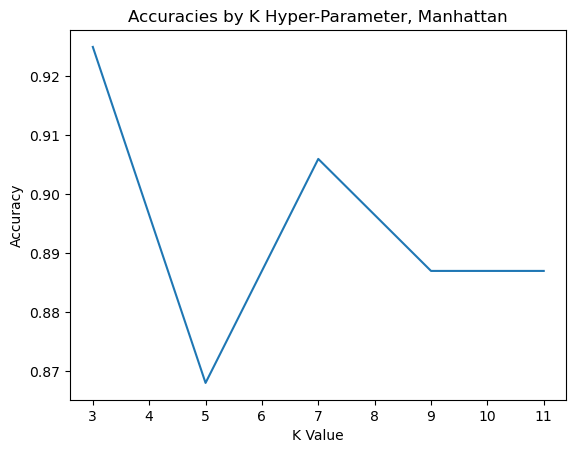

In [17]:
p = sns.lineplot(x = range(3,12,2), y = [accuracies[k] for k in range(3,12,2)])
p.set(title='Accuracies by K Hyper-Parameter, Manhattan',xlabel='K Value', ylabel='Accuracy')

K values of 3 and 5 give the same accuracy of .925

In [18]:
knn = KNeighborsClassifier(n_neighbors=3,p=1)
knn.fit(X_tr,y_tr)
predictions = knn.predict(X_te)
np.round(knn.score(X_te,y_te),3)

0.865

In [19]:
predictions.shape

(52,)

In [20]:
cm = confusion_matrix(y_te,predictions)

# true label ith row, predicted label jth column
cm

array([[28,  6],
       [ 1, 17]])

The accuracy of KNN with p=1, k=3 is 86.5%.  One fewer bad week is accurately predicted than with p=2 or euclidean distance.

In [21]:
print(f'The true positive rate is {functions.tpr(cm)} and the tnr is \
{functions.tnr(cm)}')

The true positive rate is 0.94 and the tnr is 0.82


In [22]:
gme_returns_df = functions.trade_from_close_close(gme.query('Year == 2020 or Year == 2021'),
                       this_wk_last_wk,gme.query('Year == 2019').tail(1
                       )['Adj Close'].values[0])

In [23]:
gme_returns_df.query('Year == 2021').shape

(52, 5)

In [24]:
functions.trade_labels(gme_returns_df,2021,predictions)

43844.62

In [25]:
functions.buy_and_hold(gme_returns_df,2021)

807.43

#### Q2 Minkowski P=1.5

In [26]:
accuracies={}
for k in range(3,12,2):
    knn = KNeighborsClassifier(n_neighbors=k, p = 1.5)
    knn.fit(X_tr,y_tr)
    predictions = knn.predict(X_tr)
    accuracies[k] = np.round(knn.score(X_tr,y_tr),3)

In [27]:
accuracies

{3: 0.925, 5: 0.925, 7: 0.906, 9: 0.887, 11: 0.83}

[Text(0.5, 1.0, 'Accuracies by K Hyper-Parameter}'),
 Text(0.5, 0, 'K Value'),
 Text(0, 0.5, 'Accuracy')]

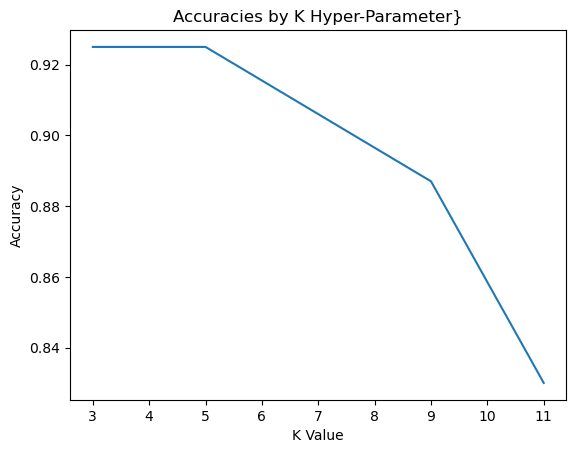

In [28]:
p = sns.lineplot(x = range(3,12,2), y = [accuracies[k] for k in range(3,12,2)])
p.set(title='Accuracies by K Hyper-Parameter}',xlabel='K Value', ylabel='Accuracy')

K values of 3 and 5 give the same accuracy of .925

In [29]:
knn = KNeighborsClassifier(n_neighbors=3,p=1.5)
knn.fit(X_tr,y_tr)
predictions = knn.predict(X_te)
np.round(knn.score(X_te,y_te),3)

0.865

In [30]:
predictions.shape

(52,)

In [31]:
cm = confusion_matrix(y_te,predictions)

# true label ith row, predicted label jth column
cm

array([[28,  6],
       [ 1, 17]])

The accuracy of KNN with p=1.5, k=3 is 86.5%.  One fewer bad week is accurately predicted than with p=2 or euclidean distance.  This is the same as with p=1.

In [32]:
print(f'The true positive rate is {functions.tpr(cm)} and the tnr is \
{functions.tnr(cm)}')

The true positive rate is 0.94 and the tnr is 0.82


In [33]:
# staggered dictionary
this_wk_last_wk = dict(zip(gme.Year_Week.unique()[1:], 
                           gme.Year_Week.unique()[:-1]))

In [34]:
gme_returns_df = functions.trade_from_close_close(gme.query('Year == 2020 or Year == 2021'),
                       this_wk_last_wk,gme.query('Year == 2019').tail(1
                       )['Adj Close'].values[0])

In [35]:
gme_returns_df.query('Year == 2021').shape

(52, 5)

In [36]:
functions.trade_labels(gme_returns_df,2021,predictions)

43844.62

In [37]:
functions.buy_and_hold(gme_returns_df,2021)

807.43

#### Q3 Nearest Centroid

In [38]:
X_tr = gme_wr_v.query('Year == 2020')
X_te = gme_wr_v.query('Year == 2021')

X_tr_greens = X_tr.query('Labels == "Green"')
X_tr_reds = X_tr.query('Labels == "Red"')

green_centroid = [X_tr_greens.mean_return.mean(),X_tr_greens.volatility.mean()]

red_centroid = [X_tr_reds.mean_return.mean(),X_tr_reds.volatility.mean()]

green_centroid, red_centroid

([3.105851785714285, 7.2518829997933265],
 [-1.9860140000000002, 4.760831174875219])

In [39]:
(X_tr_greens.apply(lambda x: (
    (x['mean_return']-green_centroid[0])**2 + 
    (x['volatility']-green_centroid[1])**2
)**.5
                 ,axis=1).values.mean(),
np.median(X_tr_greens.apply(lambda x: (
    (x['mean_return']-green_centroid[0])**2 + 
    (x['volatility']-green_centroid[1])**2
)**.5
                 ,axis=1).values))

(4.877861565769183, 4.702292852480504)

In [40]:
(X_tr_reds.apply(lambda x: (
    (x['mean_return']-red_centroid[0])**2 + 
    (x['volatility']-red_centroid[1])**2
)**.5
                 ,axis=1).values.mean(),
np.median(X_tr_reds.apply(lambda x: (
    (x['mean_return']-red_centroid[0])**2 + 
    (x['volatility']-red_centroid[1])**2
)**.5
                 ,axis=1).values))

(2.698565151132838, 2.729909383336894)

In [41]:
{"distance_to_red" : (X_tr.apply(lambda x: (
    (x['mean_return']-red_centroid[0])**2 + 
    (x['volatility']-red_centroid[1])**2
)**.5
                 ,axis=1).values.mean(),
np.median(X_tr.apply(lambda x: (
    (x['mean_return']-red_centroid[0])**2 + 
    (x['volatility']-red_centroid[1])**2
)**.5
                 ,axis=1).values)),
"distance_to_green":
 (X_tr.apply(lambda x: (
    (x['mean_return']-green_centroid[0])**2 + 
    (x['volatility']-green_centroid[1])**2
)**.5
                 ,axis=1).values.mean(),
np.median(X_tr.apply(lambda x: (
    (x['mean_return']-green_centroid[0])**2 + 
    (x['volatility']-green_centroid[1])**2
)**.5
                 ,axis=1).values))
}

{'distance_to_red': (4.868762518477502, 3.5680571679489086),
 'distance_to_green': (5.497250723801833, 5.481875123253371)}

The size of the "Green" sphere centered at the green centroid is larger than the size of the "Red" sphere centered at the red centroid.  Points of both types tend to be farther from the green centroid.

In [42]:
centroid_preds = np.where(X_te.apply(lambda x: (
    (x['mean_return']-green_centroid[0])**2 + 
    (x['volatility']-green_centroid[1])**2
)**.5, axis = 1).values < \
X_te.apply(lambda x: (
    (x['mean_return']-red_centroid[0])**2 + 
    (x['volatility']-red_centroid[1])**2
)**.5, axis = 1).values,"Green","Red")

In [43]:
centroid_preds

array(['Red', 'Green', 'Green', 'Green', 'Red', 'Red', 'Red', 'Green',
       'Green', 'Green', 'Red', 'Green', 'Red', 'Red', 'Green', 'Red',
       'Green', 'Red', 'Green', 'Green', 'Green', 'Green', 'Green', 'Red',
       'Red', 'Red', 'Red', 'Red', 'Green', 'Red', 'Red', 'Red', 'Red',
       'Green', 'Red', 'Red', 'Red', 'Red', 'Red', 'Red', 'Red', 'Red',
       'Red', 'Green', 'Red', 'Green', 'Red', 'Red', 'Red', 'Green',
       'Red', 'Red'], dtype='<U5')

In [44]:
cm = confusion_matrix(gme_wr_v.query("Year == 2021").Labels.values,
                centroid_preds)

In [45]:
functions.tpr(cm), functions.tnr(cm)

(0.79, 0.67)

In [46]:
returns_df = functions.trade_from_close_close(gme,this_wk_last_wk)

In [47]:
functions.trade_labels(returns_df,2021,np.where(centroid_preds=='Green',1,0))

31068.38

In [48]:
functions.buy_and_hold(returns_df,2021)

807.43

Using the centroids is worse than KNN but better than buy and hold. 

##### Question 4 (Domain Transformation)

take k = 3,5,7,9,11. 
For each value of k compute the accuracy of this classifier. On x axis you plot k and on y-axis you plot accuracy. What is the optimal value of k for year 1?

Domain Transformation (x ,y ) → (x2,x y √2,y2)

In [49]:
gme_dt = gme_wr_v.copy(deep=True)

In [50]:
gme_dt['mr_2'] = np.square(gme_dt.mean_return)
gme_dt['v_2'] = np.square(gme_dt.volatility)
gme_dt['mr_v_sqrt2'] = np.prod([gme_dt.mean_return.values,
                                gme_dt.volatility.values,np.sqrt(2*np.ones(
                                    shape=gme_wr_v.shape[0]))],axis=0)

In [51]:
gme_dt

,Year,Week_Number,mean_return,volatility,Labels,mr_2,v_2,mr_v_sqrt2
158,2020,0,-1.5160,7.493918,Red,2.298256,56.158802,-16.066568
159,2020,1,-1.5324,3.426839,Red,2.348250,11.743222,-7.426442
160,2020,2,-2.4704,6.280646,Red,6.102876,39.446508,-21.942523
161,2020,3,-2.3000,3.391904,Red,5.290000,11.505011,-11.032815
162,2020,4,-2.3190,1.496155,Red,5.377761,2.238479,-4.906731
...,...,...,...,...,...,...,...,...
258,2021,48,-2.8324,4.045923,Red,8.022490,16.369497,-16.206426
259,2021,49,-1.4430,6.241354,Red,2.082249,38.954497,-12.736794
260,2021,50,-0.0922,8.972470,Red,0.008501,80.505226,-1.169925
261,2021,51,-0.5565,1.666374,Red,0.309692,2.776801,-1.311452


In [52]:
scaler = StandardScaler()
le = LabelEncoder()

In [53]:
X = gme_dt[['mr_2', 'v_2', 'mr_v_sqrt2']].values
y = gme_dt[['Labels']].values

y = 1 - le.fit_transform(np.ravel(y))
X_tr = X[gme_wr_v.Year == 2020]
y_tr = y[gme_wr_v.Year == 2020]
X_te = X[gme_wr_v.Year == 2021]
y_te = y[gme_wr_v.Year == 2021]
scaler.fit(X_tr)
X_tr = scaler.transform(X_tr)
X_te = scaler.transform(X_te)

1.take k = 3,5,7,9,11. For each value of k compute the accuracy of this classifier. On x axis you plot k and on y-axis you plot accuracy. What is the optimal value of k for year 1?

In [54]:
X = gme_wr_v
X_train = scaler.transform(X_tr)
accuracies={}
for k in range(3,12,2):
    knn = KNeighborsClassifier(n_neighbors=k,p=2)
    knn.fit(X_tr,y_tr)
    predictions = knn.predict(X_tr)
    accuracies[k] = np.round(knn.score(X_tr,y_tr),3)

In [55]:
accuracies

{3: 0.925, 5: 0.906, 7: 0.868, 9: 0.887, 11: 0.83}

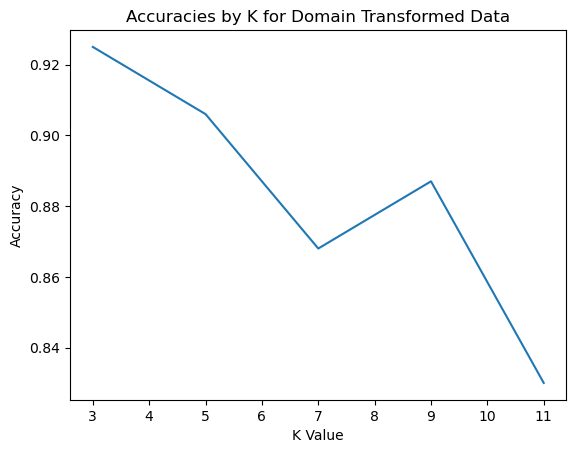

In [58]:
p = sns.lineplot(x = range(3,12,2), y = [accuracies[k] for k in range(3,12,2)])
p.set(title = 'Accuracies by K for Domain Transformed Data',
      xlabel = 'K Value', ylabel = 'Accuracy')
plt.savefig('./DomainTAccuracies.png')

The best K value of 3 gives y1 accuracy of .925.

In [59]:
knn = KNeighborsClassifier(n_neighbors=3,p=2)
knn.fit(X_tr,y_tr)
predictions = knn.predict(X_te)
np.round(knn.score(X_te,y_te),3)

0.885

In [60]:
cm = confusion_matrix(y_te,predictions)
cm

array([[29,  5],
       [ 1, 17]])

The accuracy of KNN with k=3 is 88.5%

Same accuracy as with non-transformed k-NN

In [61]:
functions.tpr(cm), functions.tnr(cm)

(0.94, 0.85)

In [62]:
trading_strategies(gme,2021,this_wk_last_wk,predictions)

(44865.61, 807.43)

The trading results from regular knn and DT knn are the same.

##### Q5 k-Predicted Neighbors

In [63]:
scaler = StandardScaler()
le = LabelEncoder()

In [64]:
X = gme_wr_v[['mean_return','volatility']].values
y = gme_wr_v[['Labels']].values

y = 1 - le.fit_transform(np.ravel(y))
X_tr = X[gme_wr_v.Year == 2020]
y_tr = y[gme_wr_v.Year == 2020]
X_te = X[gme_wr_v.Year == 2021]
y_te = y[gme_wr_v.Year == 2021]
scaler.fit(X_tr)
X_tr = scaler.transform(X_tr)
X_te = scaler.transform(X_te)

In [65]:
accuracies={}
for k in range(3,12,2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_tr,y_tr)
    knn.fit(X_tr,knn.predict(X_tr))
    predictions = knn.predict(X_tr)
    accuracies[k] = np.round(knn.score(X_tr,y_tr),3)

In [66]:
accuracies

{3: 0.925, 5: 0.925, 7: 0.868, 9: 0.868, 11: 0.868}

[Text(0.5, 1.0, 'Accuracies by K Hyper-Parameter}'),
 Text(0.5, 0, 'K Value'),
 Text(0, 0.5, 'Accuracy')]

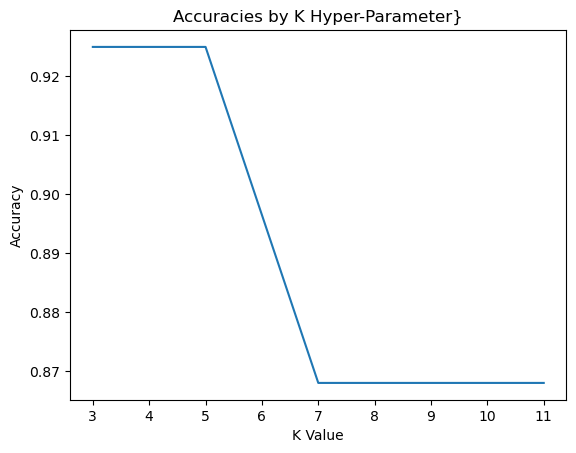

In [67]:
p = sns.lineplot(x = range(3,12,2), y = [accuracies[k] for k in range(3,12,2)])
p.set(title='Accuracies by K Hyper-Parameter}',xlabel='K Value', ylabel='Accuracy')

K values of 3 and 5 give the same accuracy of .925



The optimal k from y1 is 3.

In [68]:
knn = KNeighborsClassifier(n_neighbors=3,p=2)
knn.fit(X_tr,y_tr)
knn.fit(X_tr,knn.predict(X_tr))
predictions = knn.predict(X_te)
np.round(knn.score(X_te,y_te),3)

0.865

In [69]:
cm = confusion_matrix(y_te,predictions)
cm

array([[28,  6],
       [ 1, 17]])

Same accuracy as with non-transformed k-NN

In [70]:
functions.tpr(cm), functions.tnr(cm)

(0.94, 0.82)

In [71]:
trading_strategies(gme,2021,this_wk_last_wk,predictions)

(43844.62, 807.43)

There is not an improvement over regular knn.  There is slighly lower accuracy and return on $100

##### k-Hyperplanes -- ToDo

In [72]:
scaler = StandardScaler()
le = LabelEncoder()

In [73]:
X = gme_wr_v[['mean_return','volatility']].values
y = gme_wr_v[['Labels']].values

y = 1 - le.fit_transform(np.ravel(y))
X_tr = X[gme_wr_v.Year == 2020]
y_tr = y[gme_wr_v.Year == 2020]
X_te = X[gme_wr_v.Year == 2021]
y_te = y[gme_wr_v.Year == 2021]
scaler.fit(X_tr)
X_tr = scaler.transform(X_tr)
X_te = scaler.transform(X_te)

In [74]:
X_tr

array([[-6.06146833e-01,  3.58051924e-01],
       [-6.10624617e-01, -6.69587289e-01],
       [-8.66732041e-01,  5.14913732e-02],
       [-8.20206769e-01, -6.78414362e-01],
       [-8.25394446e-01, -1.15741806e+00],
       [-2.09808308e-01, -3.42424546e-01],
       [ 1.12046096e-01, -7.78722865e-01],
       [-1.54272860e-01, -1.03608041e+00],
       [-7.85749672e-01, -2.47547503e-01],
       [ 3.02188111e-01, -3.17166323e-01],
       [ 7.93215393e-01,  1.07186160e+00],
       [-1.17482545e+00,  7.11052033e-01],
       [ 4.74145953e-01, -2.21890097e-01],
       [-2.31218268e+00, -2.50251858e-01],
       [ 2.16536962e+00, -4.10914099e-01],
       [ 1.35932747e+00,  2.70742659e+00],
       [-1.88456921e-01,  1.18962626e+00],
       [ 1.25295279e+00,  1.17970393e+00],
       [-1.20546005e+00, -2.59476933e-01],
       [-1.06757705e+00, -6.36017077e-01],
       [-2.13030128e-01, -1.71909294e-01],
       [-3.32906423e-01,  3.49946881e-01],
       [-5.85465671e-02, -2.91865951e-01],
       [ 7.

In [75]:
def vectors_from_p1_P2(a_coords, B_coords):
    """compute and return an array of vectors from point a to each point in 
    an array of point coordinates B"""
    return B_coords - a_coords

def hyperplane_labeler(point_a, points_B, X, labels):
    """ARGUMENTS: point_a --> the point for which a label is returned.
    points_B --> the nearest neighbors, used to construct hyperplanes.  
    X --> the points for which subpaces, pos or negative are determined.
    labels --> the mode label of points in the negative subspace is determined
    for each point in points_B 
    RETURN: the mode of the modes (points_B hyperplane-generated labels.) """
    
    vectors_a_B = vectors_from_p1_P2(point_a,points_B)
    points_B_labels = []
    for point_b,vector in zip(points_B,vectors_a_B):
    # get dot product of vectors from a to each b with each vector from point
    # b to ech point in X.  
        points_B_labels.append(mode(
            labels[np.where(
            # get points in negative subspace
                np.dot(vector,
                        vectors_from_p1_P2(point_b,X).T) 
            # note: dot product of vector with a zero vector is zero, so >= 0
                
                                <0,True,False)])[0])
    return mode(points_B_labels)[0]

To-Do: Graphical representation of hyperplane labeler

In [76]:
def hyperplane_accuracies_k(X,y_tr):
    accuracies = {}
    for k in range(3,12,2):
        nn = NearestNeighbors(n_neighbors=k)

        nn.fit(X)
        nn.kneighbors(return_distance=False)

        nn.fit(X)
        nn.kneighbors()
        neighbors_dict = {i:x for i,x in enumerate(nn.kneighbors(X,
                                                    return_distance=False))}
        hyper_preds = {}
        for i in range(0,X.shape[0]):
            hyper_preds[i] = hyperplane_labeler(X[i] #label neighbors w.r.t pt_i
                              , X[[True if j in neighbors_dict[i] else False for 
                              j in range(0,X.shape[0])]], 
                              # exclude pt_i when determining labels of nn.
                              np.delete(X,i,axis=0),np.delete(y_tr,i))
            
        accuracies[k] = np.round(sum(y_tr==hyper_preds)/len(y_tr),3)
    return accuracies

In [77]:
hyperplane_accuracies_k(X_tr,y_tr)

{3: 0.0, 5: 0.0, 7: 0.0, 9: 0.0, 11: 0.0}

I am getting quite low accuracies that seem to alternate between .528 and .427.  I will proceed with a k of 5.

In [78]:
nn = NearestNeighbors(n_neighbors=3)
nn.fit(X_tr)
nn.kneighbors()

(array([[0.27336059, 0.40234814, 0.63167068],
        [0.10719514, 0.14740231, 0.20976796],
        [0.30981025, 0.40234814, 0.43023557],
        [0.11808546, 0.16130539, 0.20976796],
        [0.43023373, 0.46348944, 0.47903179],
        [0.15948757, 0.17054569, 0.31918478],
        [0.13419332, 0.18195889, 0.19984933],
        [0.07304598, 0.16945879, 0.19081195],
        [0.17244305, 0.2875719 , 0.30981025],
        [0.17165959, 0.19658855, 0.21938202],
        [0.47221652, 0.61569579, 0.82749289],
        [0.22116426, 0.66933134, 0.6873328 ],
        [0.06811453, 0.17868243, 0.19658855],
        [0.3573052 , 0.80860509, 1.10676108],
        [0.70578809, 1.03735516, 1.45736007],
        [1.12409949, 1.21684407, 1.24137576],
        [0.72029797, 0.85201356, 0.93058086],
        [0.47221652, 0.6635172 , 0.67824261],
        [0.40099152, 0.41987988, 0.45982382],
        [0.25097726, 0.28139889, 0.40099152],
        [0.17054569, 0.19558827, 0.26914931],
        [0.27336059, 0.53544766, 0

In [79]:
def hyperplane_test_set_labeler(X_tr,y_tr,X_te):
    nn = NearestNeighbors(n_neighbors=3)
    nn.fit(X_tr)

    nn.kneighbors(X_tr,return_distance=False)

    nn.fit(X_tr)
    nn.kneighbors(X_tr)
    neighbors_dict = {x[0]:x[1:] for x in nn.kneighbors(X_tr,
                                                return_distance=False)}


    hyper_preds = hyperplane_labeler(X_tr[1],X_tr[[True if i in 
                                    neighbors_dict[1] else False for 
                                     i in range(0,X_tr.shape[0])]],
                       np.delete(X_tr,1,axis=0),np.delete(y_tr,1))

    accuracies[k] = np.round(sum(y_tr==hyper_preds)/len(y_tr),3)
    return accuracies

###### Junk

labs = []
for i in range (0,X_tr.shape[0]):
    
    neighbors = [True if n in neighbors_dict[i]  else False 
                    for n in range(0,X_tr.shape[0])]
    print(f'\
{hyperplane_labeler(X_tr[i],X_tr[neighbors], np.delete(X_tr,i,axis=0),np.delete(y_tr,i))}\
')

X_tr[0]

hyperplane_labeler()

accuracies={}
for k in range(3,12,2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_tr,y_tr)
    knn.fit(X_tr,knn.predict(X_tr))
    predictions = knn.predict(X_tr)
    accuracies[k] = np.round(knn.score(X_tr,y_tr),3)

accuracies

There is not an improvement over regular knn.  There is slighly lower accuracy and return on $1000